In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import csv
import openpyxl
from itertools import islice

# Convert QuPath data to pandas

In [3]:
input_file = '/Users/jacquemi/working_dir/QuPath/Nissll/Result/404_cell_position.txt'
output_file = './404_cell_position.xls'

wb = openpyxl.Workbook()
ws = wb.worksheets[0]

with open(input_file, 'r') as data:
    reader = csv.reader(data, delimiter='\t')
    for row in reader:
        ws.append(row) 

In [4]:
data = ws.values
cols = next(data)[1:]
data = list(data)
print(data[0])
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df_404 = pd.DataFrame(data, index=idx, columns=cols)

('SLD_0000404.vsi - 20x_01', 'PathDetectionObject', '', 'S1', 'Polygon', '10994.1', '1579.9', '0.9553', '204.0999', '51.3083', '0.9743', '1', '17.1725', '14.9909', '0.4352', '0.4596', '0.0985', '0.6285', '0.1088', '-0.0564', '-0.065', '-0.1214', '0.0345', '0.0307')


In [ ]:
df_404

In [5]:
centroid_x = df_404['Centroid X µm'].to_numpy(dtype=float)
centroid_y = df_404['Centroid Y µm'].to_numpy(dtype=float)

#  analyse

In [18]:
button=centroid_y.min()
top=centroid_y.max()
z_length = 50 # um
nb_slice = 100

# compute fractions

In [19]:
length = top - button
fractions=np.zeros(centroid_y.shape[0], dtype=float)
for index, point in enumerate(centroid_y):
    fractions[index]=(point-button) / (length)

# Plot positions and fraction histogram

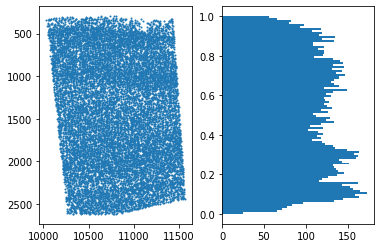

In [20]:
plt.subplot(121)
plt.gca().invert_yaxis()
_ = plt.scatter(centroid_x, centroid_y, s=1)
plt.subplot(122)
fract_hist = plt.hist(fractions, nb_slice, orientation='horizontal')

In [21]:
nb_points_per_bin = fract_hist[0]

# Split data by slice

In [22]:
y_length = centroid_y.max() - centroid_y.min()
slice_max_y = centroid_y.min()
last_y = centroid_y.min()
y_length / nb_slice
masks=[]
for i in range(nb_slice):
    slice_max_y += (y_length / nb_slice)
    masks.append(np.where((centroid_y >= last_y) & (centroid_y < slice_max_y))[0])
    last_y = slice_max_y
    

In [23]:
slice_points = []
for mask in masks:
    x=centroid_x[mask]
    y=centroid_y[mask]
    slice_points.append(np.vstack((x, y)).T)

# Compute slices area thanks to from scipy.spatial.ConvexHull

In [24]:
hulls = []
for i in range(nb_slice):
    hulls.append(ConvexHull(slice_points[i]))

slice Area: 12039.274999999992


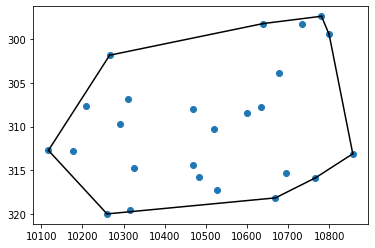

slice Area: 26817.07950000001


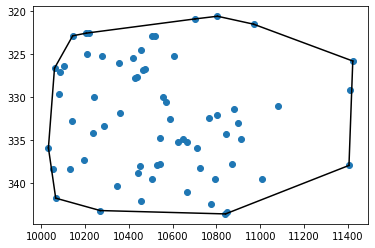

slice Area: 26872.416499999974


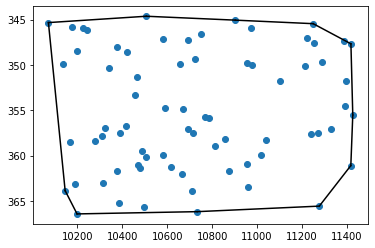

slice Area: 26836.772000000015


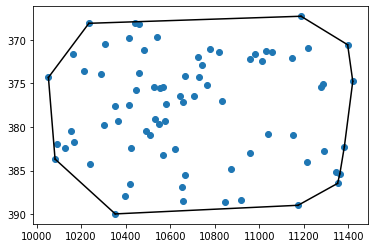

slice Area: 27788.152000000002


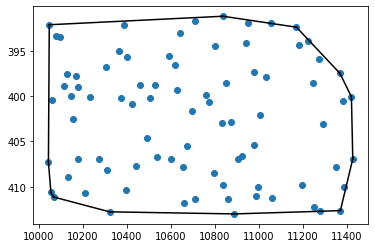

slice Area: 26239.39299999998


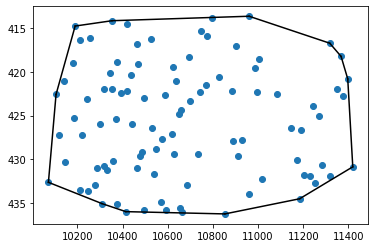

slice Area: 28422.377999999982


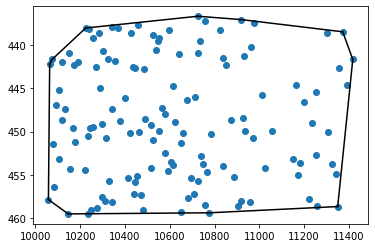

slice Area: 29011.259499999986


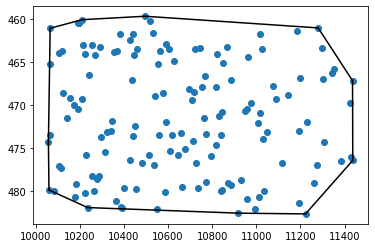

slice Area: 29461.29149999996


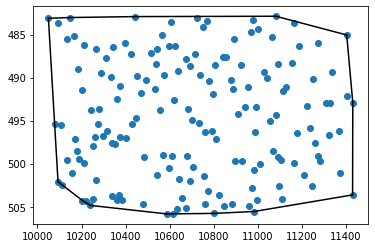

slice Area: 30750.761499999946


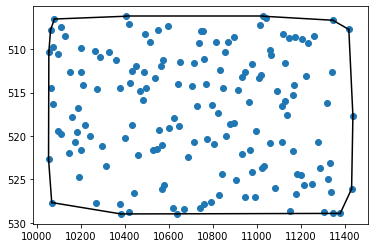

slice Area: 29773.347499999985


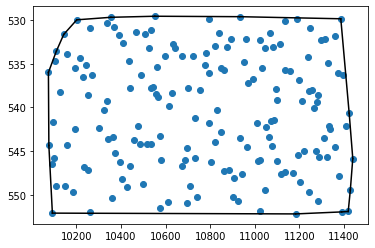

slice Area: 30089.286000000036


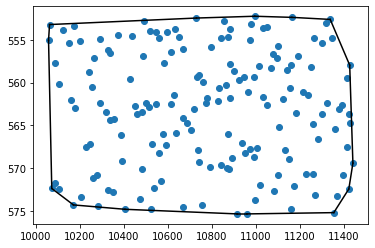

slice Area: 29041.63300000003


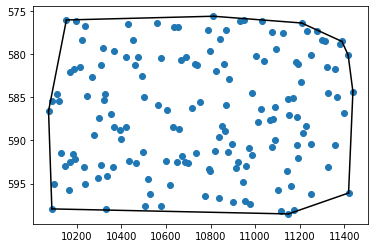

slice Area: 28505.43450000001


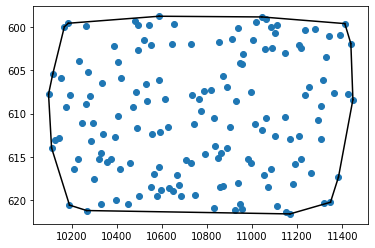

slice Area: 28610.60050000014


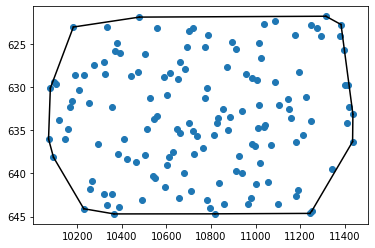

slice Area: 28912.454500000036


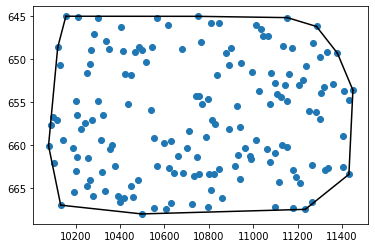

slice Area: 28729.68649999998


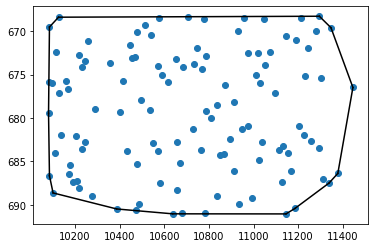

slice Area: 28822.24049999999


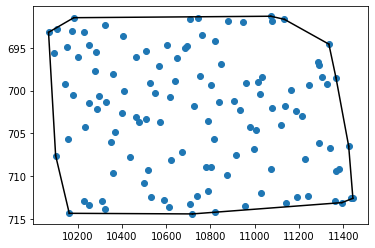

slice Area: 28280.172500000015


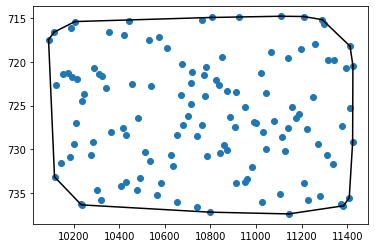

slice Area: 27745.72499999998


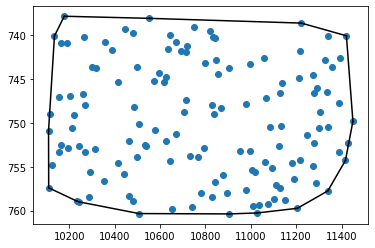

slice Area: 29332.14900000005


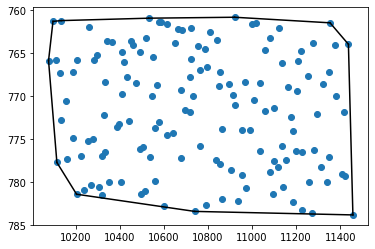

slice Area: 29607.058499999996


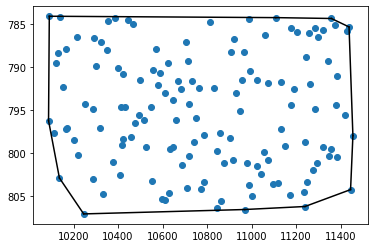

slice Area: 29275.794000000045


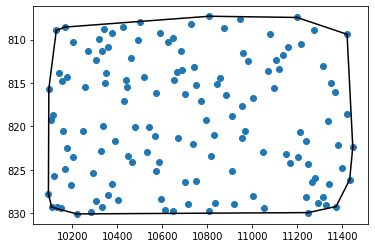

slice Area: 29569.237000000117


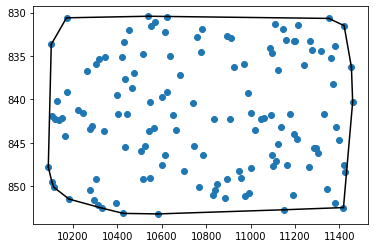

slice Area: 29881.987499999992


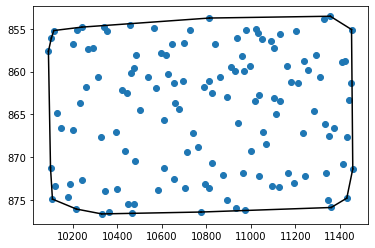

slice Area: 29471.486999999986


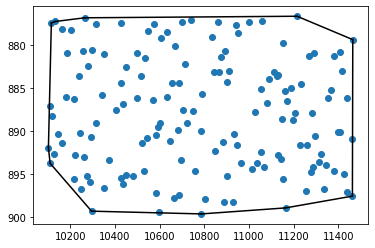

slice Area: 29353.372000000014


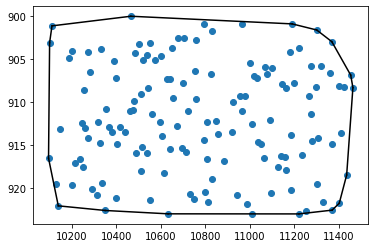

slice Area: 30062.11699999998


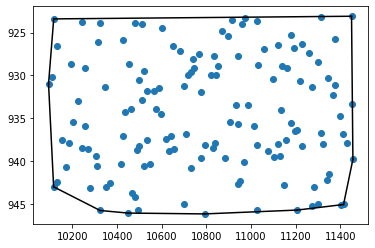

slice Area: 29812.064000000006


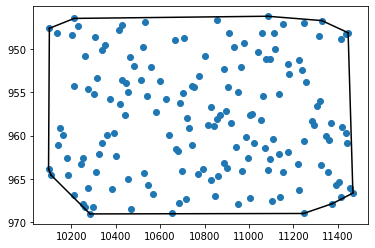

slice Area: 28973.739000000023


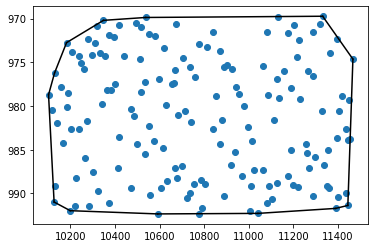

slice Area: 27424.410500000064


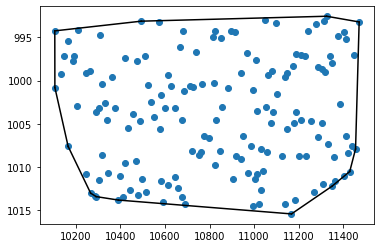

slice Area: 29002.405000000086


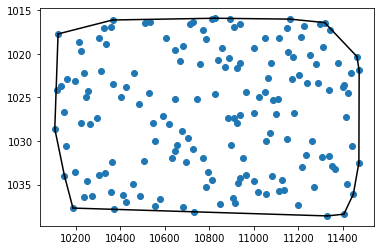

slice Area: 29873.775000000012


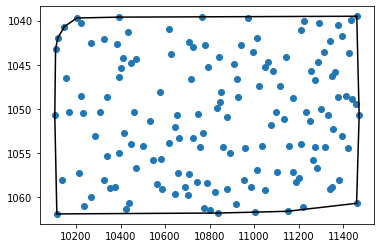

slice Area: 29503.13999999996


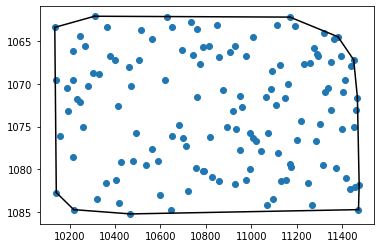

slice Area: 29190.715000000146


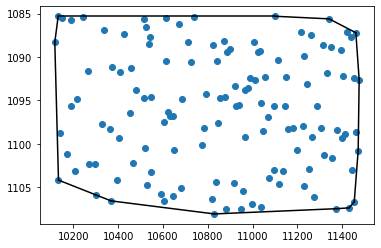

slice Area: 28176.785000000036


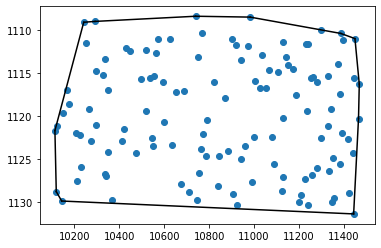

slice Area: 28669.505000000056


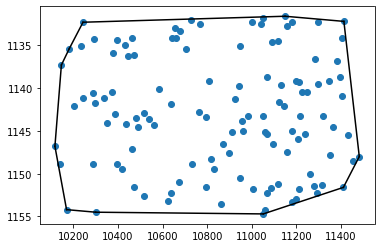

slice Area: 29095.189999999973


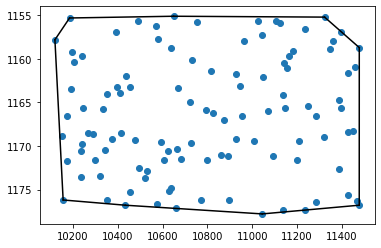

slice Area: 28951.000000000095


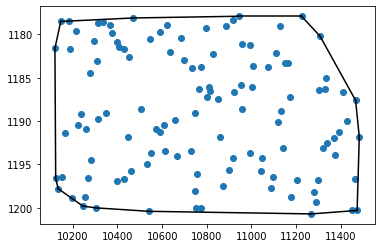

slice Area: 29245.310000000052


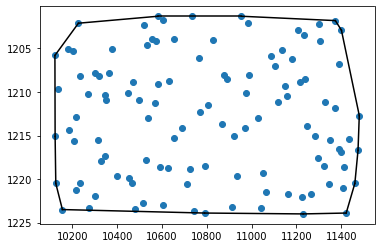

slice Area: 27958.950000000004


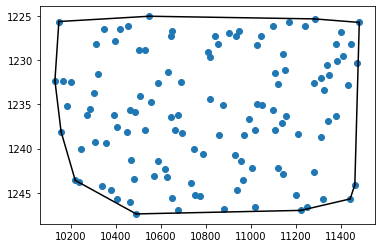

slice Area: 28124.46000000002


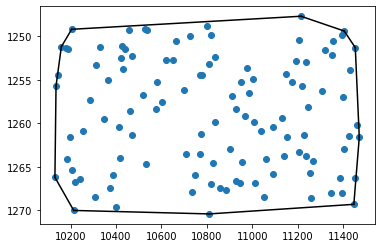

slice Area: 28128.620000000075


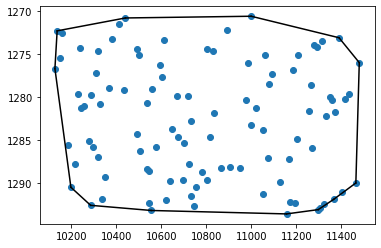

slice Area: 28336.354999999927


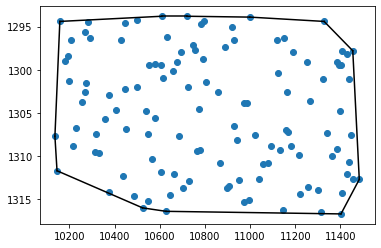

slice Area: 28596.385000000024


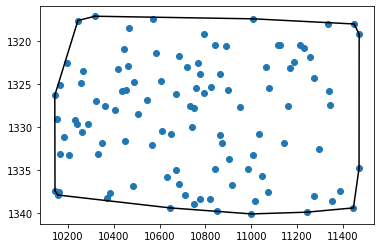

slice Area: 27032.179999999982


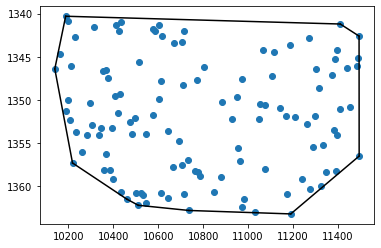

slice Area: 28919.419999999947


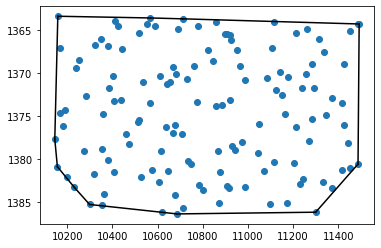

slice Area: 28921.035000000167


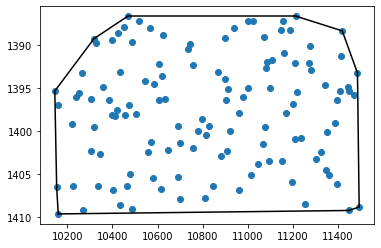

slice Area: 27390.309999999972


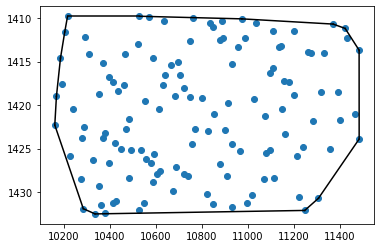

slice Area: 28259.145000000277


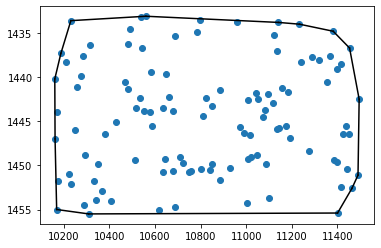

slice Area: 28318.04999999998


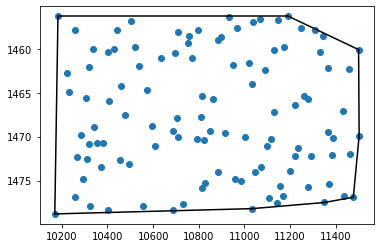

slice Area: 29618.6


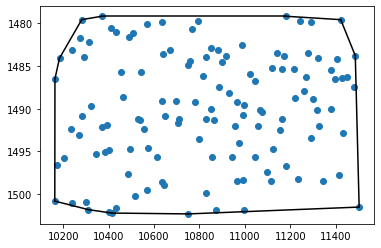

slice Area: 29036.854999999818


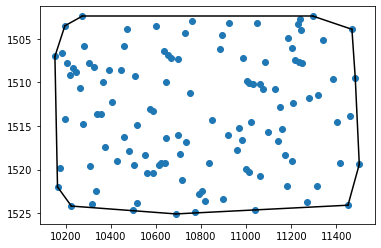

slice Area: 28242.929999999993


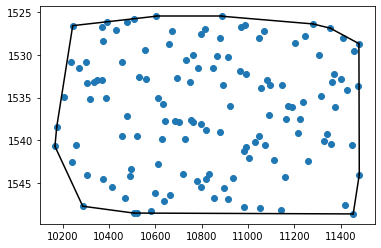

slice Area: 28082.610000000044


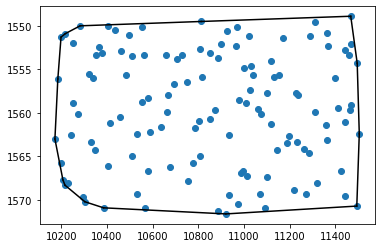

slice Area: 27302.860000000037


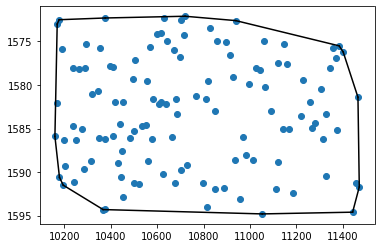

slice Area: 29320.795000000093


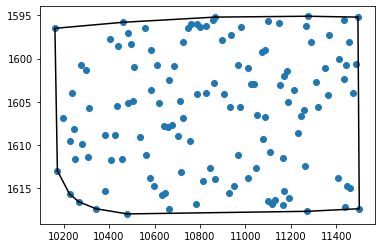

slice Area: 29096.854999999916


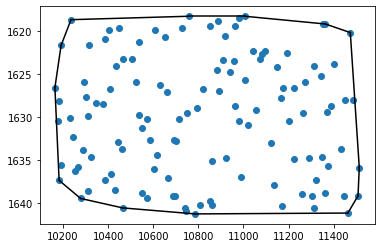

slice Area: 29484.7699999999


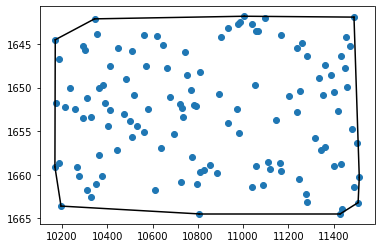

slice Area: 28556.12999999997


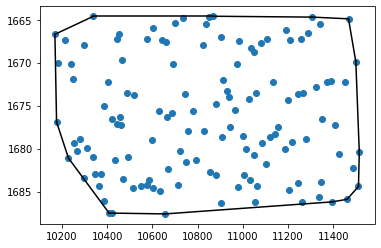

slice Area: 29170.375000000015


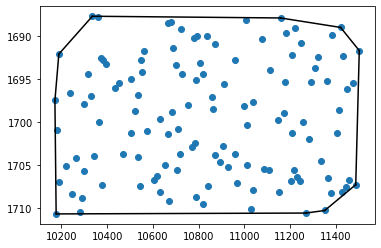

slice Area: 27694.635000000064


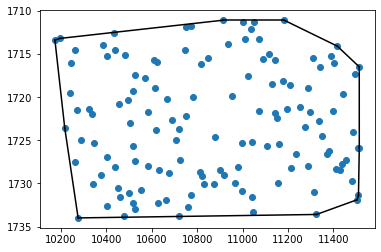

slice Area: 28838.585000000017


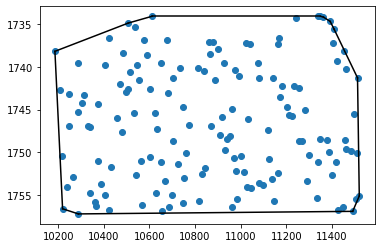

slice Area: 27846.049999999854


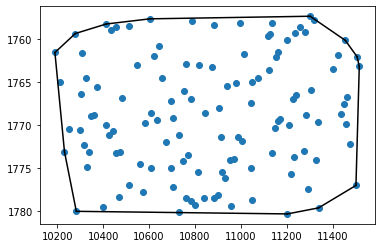

slice Area: 29356.38500000007


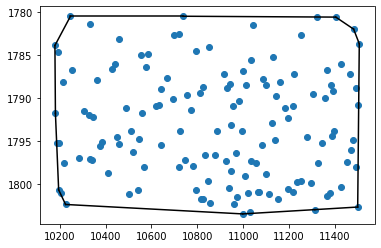

slice Area: 28235.820000000185


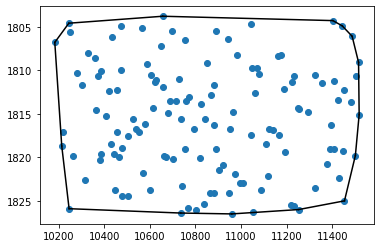

slice Area: 28620.275000000016


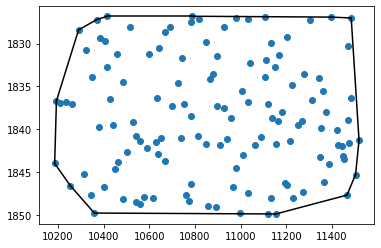

slice Area: 29097.425000000057


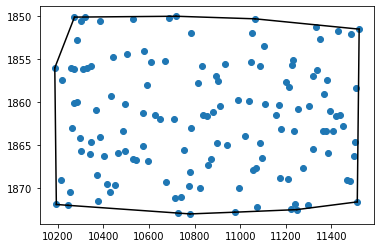

slice Area: 28785.614999999965


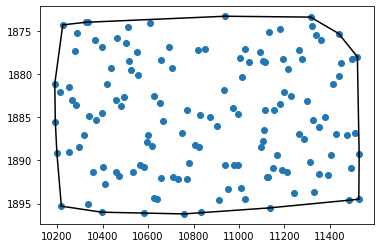

slice Area: 28656.94000000015


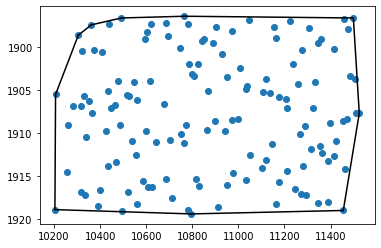

slice Area: 28399.119999999995


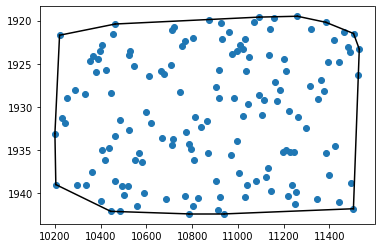

slice Area: 27684.810000000198


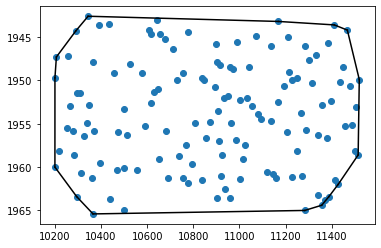

slice Area: 28039.030000000053


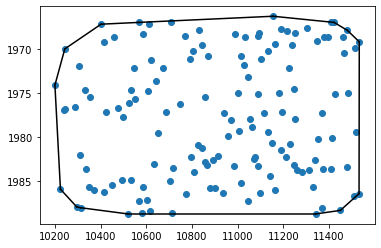

slice Area: 27902.144999999968


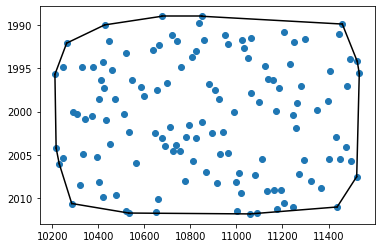

slice Area: 28066.519999999844


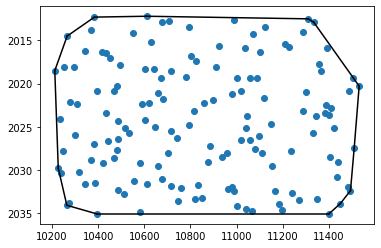

slice Area: 28604.65000000032


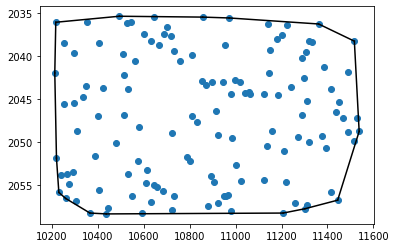

slice Area: 26920.534999999923


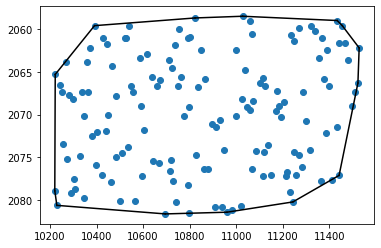

slice Area: 29551.569999999665


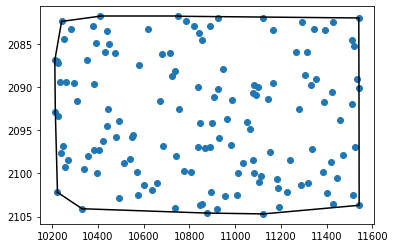

slice Area: 28253.665000000186


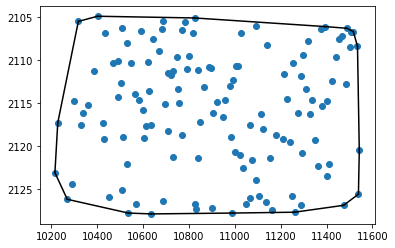

slice Area: 27488.94500000021


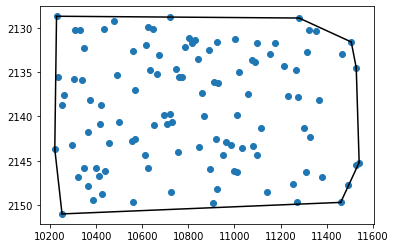

slice Area: 26482.78499999971


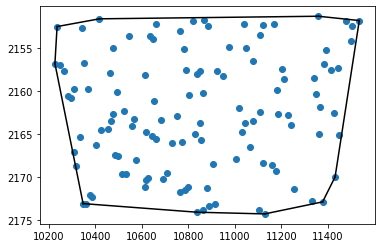

slice Area: 27283.34000000009


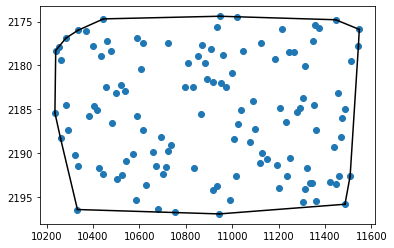

slice Area: 28436.30999999991


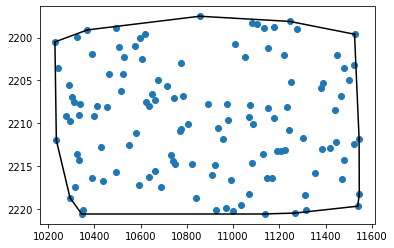

slice Area: 28064.77000000004


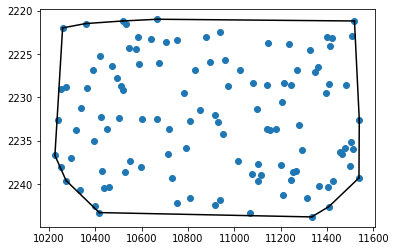

slice Area: 28323.17499999988


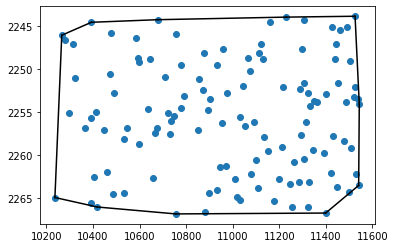

slice Area: 27613.00999999978


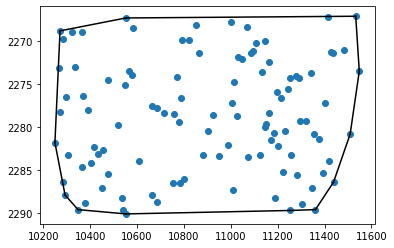

slice Area: 25088.489999999823


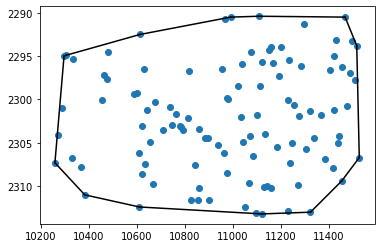

slice Area: 26328.7100000002


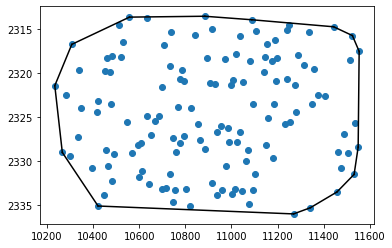

slice Area: 26874.724999999613


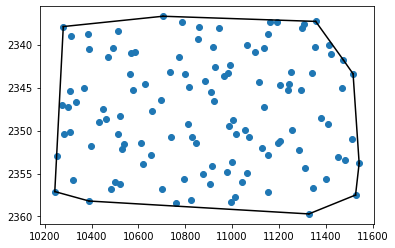

slice Area: 28468.609999999644


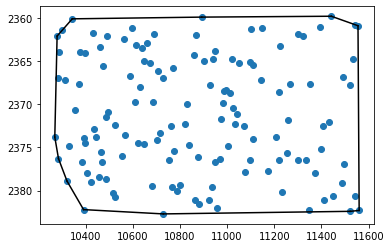

slice Area: 27949.76999999975


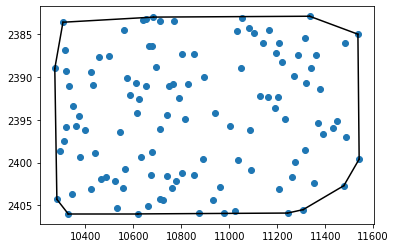

slice Area: 28231.91500000017


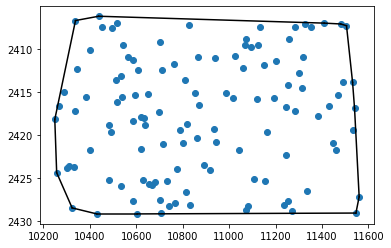

slice Area: 26089.454999999907


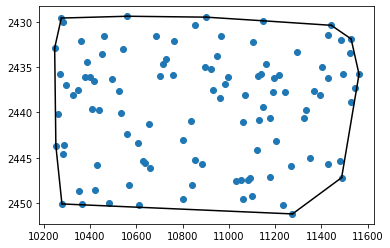

slice Area: 25174.480000000036


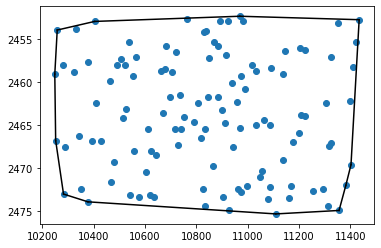

slice Area: 22177.074999999968


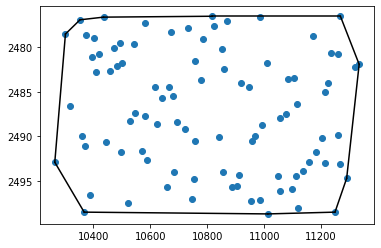

slice Area: 19053.13500000001


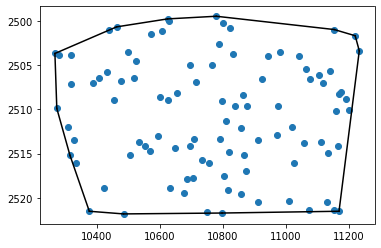

slice Area: 15906.769999999915


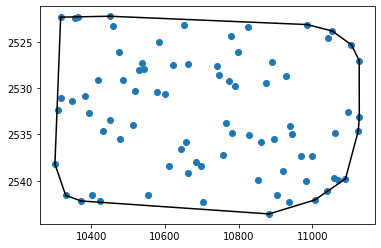

slice Area: 16402.21499999994


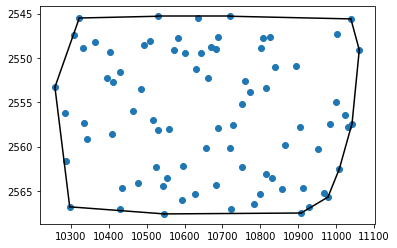

slice Area: 13676.645000000088


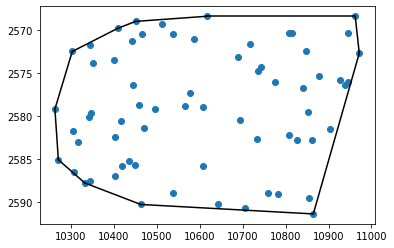

slice Area: 11764.000000000027


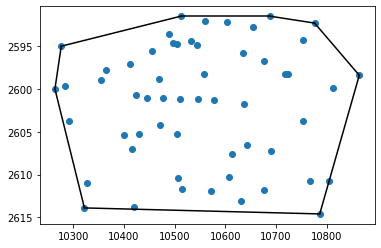

In [25]:
areas = []
for i in range(nb_slice):
    plt.gca().invert_yaxis()
    plt.plot(slice_points[i][:,0], slice_points[i][:,1], 'o')
    for simplex in hulls[i].simplices:
        plt.plot(slice_points[i][simplex, 0], slice_points[i][simplex, 1], 'k-')
    print('slice Area:', hulls[i].volume)
    areas.append(hulls[i].volume)
    plt.show()

(array([ 2.,  1.,  2.,  1.,  0.,  1.,  0., 11., 47., 35.]),
 array([11764.     , 13662.67615, 15561.3523 , 17460.02845, 19358.7046 ,
        21257.38075, 23156.0569 , 25054.73305, 26953.4092 , 28852.08535,
        30750.7615 ]),
 <a list of 10 Patch objects>)

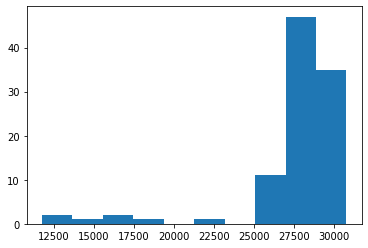

In [26]:
plt.hist(areas)

# Compute densities from fractions and volume

In [27]:
densities = nb_points_per_bin / (np.array(areas) * z_length)

(array([ 1.,  2.,  2.,  0.,  7., 23., 25., 21., 12.,  7.]),
 array([4.15307400e-05, 4.89987980e-05, 5.64668559e-05, 6.39349139e-05,
        7.14029718e-05, 7.88710298e-05, 8.63390877e-05, 9.38071457e-05,
        1.01275204e-04, 1.08743262e-04, 1.16211320e-04]),
 <a list of 10 Patch objects>)

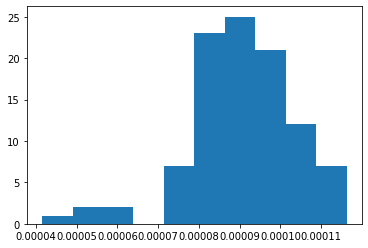

In [28]:
plt.hist(densities) # nb_cell by um3

(array([ 1.,  0.,  3.,  5.,  3., 10., 29., 30., 11.,  8.]),
 array([ 25. ,  39.8,  54.6,  69.4,  84.2,  99. , 113.8, 128.6, 143.4,
        158.2, 173. ]),
 <a list of 10 Patch objects>)

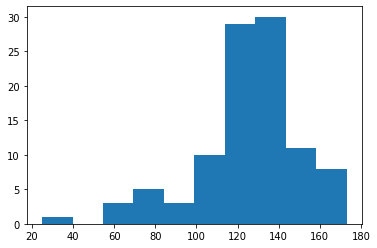

In [29]:
plt.hist(nb_points_per_bin)

In [43]:
arr = np.array([[2,40],[3,20],[1,30]])

In [44]:
arr

array([[ 2, 40],
       [ 3, 20],
       [ 1, 30]])

In [45]:
np.sort(arr, axis=1)

array([[ 2, 40],
       [ 3, 20],
       [ 1, 30]])